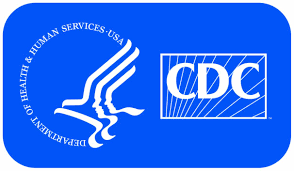
image credit: https://medworksmedia.com/cdc-logo/

# Misinformation & COVID-19:
## Prediction and Classification Project by Sarah Jack


Curtailing the spread of misinformation about COVID-19 is crucial to preventing the spread of unneccessary illness and death. To this end, it is paramount that the CDC understands what populations are most at risk for holding misinformed views. This project can be used by organizations like the CDC to target at-risk groups in case of another outbreak of viral illness like COVID-19. 

This project uses survey data from the American National Election Studies Exploratory Testing Survey from April 2020. The survey garnered  over 3k responses to questions spanning topics from electoral politics, to social issues, to matters of public health. 

This notebook aims to classify if respondents are misinformed about COVID-19 based on their answers to other survey questions, as well as demographic variables. 

The target variable for the models is a COVID-19 misinformation score. The score was calculated by aaggregating responses to two questions in the survey that ask respondents if they believe COVID-19 was manufacted in a lab and if there was a publicly availble vaccine at the time. 

I find that .... <insert main findings> 





# Set up: Import Libraries & Load in Data

In [17]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels as sm
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import mean_squared_error as mse
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, plot_roc_curve, plot_confusion_matrix
from sklearn.metrics import log_loss, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from xgboost import XGBClassifier
from scipy.stats import uniform
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [18]:
anes = pd.read_csv('data/anes_pilot_2020ets_csv.csv')
data = anes.copy(deep = True)

# EDA

In [19]:
#about 3k responses across 470 questions
data.shape

(3080, 470)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3080 entries, 0 to 3079
Columns: 470 entries, V1 to vidknow
dtypes: float64(3), int64(453), object(14)
memory usage: 11.0+ MB


In [21]:
data.describe()

,V1,_v1,follow,reg1,votemail1a,votemail1b,votecount,votemail2,voterid1,voterid2,...,rr_scale,white,black,namer,asian,hpi,mixed,race7,vidx,vidknow
count,3080.00000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,...,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3078.000000,3080.000000
mean,1540.50000,3798.924026,1.644156,1.290584,46.673377,39.099351,3.329221,2.751948,1.547727,3.457468,...,8.692857,0.701623,0.106169,0.005195,0.036364,0.001948,0.034091,1.785714,1.816439,0.407792
std,889.26374,10553.322567,0.876972,0.724222,42.500686,36.917557,1.093571,1.310572,0.776603,2.807707,...,5.998361,0.457620,0.308104,0.071899,0.187224,0.044101,0.282326,1.430945,1.272351,0.491504
min,1.00000,464.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,770.75000,1643.750000,1.000000,1.000000,2.000000,3.000000,3.000000,2.000000,1.000000,1.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,1540.50000,2233.500000,1.000000,1.000000,88.000000,7.000000,3.000000,3.000000,1.000000,2.000000,...,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000
75%,2310.25000,3211.250000,2.000000,1.000000,88.000000,77.000000,4.000000,4.000000,2.000000,7.000000,...,11.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,1.000000
max,3080.00000,255418.000000,9.000000,4.000000,88.000000,77.000000,9.000000,9.000000,9.000000,9.000000,...,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000,9.000000,3.000000,1.000000


# Data Cleaning

## Dropping Irrelevant Columns 
There are 460 columns, not all of which are necessary. The first 9 columns contain metadata about the survey and survey collection method. This includes information like what browser the respondent used to take the survey, the version of that browser, which day in the week the respondent completed the survey on, etc. This information is not pertinant for my analysis. 

I elected to drop a number of columns that contain answers for questions that survyors asked based on the self-reported ethnoracial identity of the respondent. Because the answers for these questions are specific to each respondent, they can not be generalized across the dataframe. 

I also removed a number of demographic variables. This survey contains mulitple variables for political party identification and ethnoracial self-identification. This level of repition was unnecessary for the scope of this project. 

I dropped questions the surveyors used as check-points to make sure respondents were filling out the survey correctly. An example of this is "check" which asked respondents to click a certain box so that the surveyors could be sure the respondent's screen was working. Another meta-data question asked respondents if they have ever been attacked by a shark. Questions like these allow surveyors to weed out joke responses. 

In [23]:
#look at all the column names
#for col in data.columns:
   # print(col)

In [24]:
# dropping irrelevant columns 
data.drop(inplace=True, columns=[ 'votemail1b', 'V1', 'StartDate', 'EndDate', '_v1', 'RecordedDate', 
                                 'ResponseId','qmetadata_Browser', 'qmetadata_Version', '_v2', 
                                 'qmetadata_Resolution', 'check','relig1_11_TEXT', 'mauga', 'pk_cjus', 
                                 'pk_germ', 'ethnic1', 'ethnic2', 'ethnic3', 'mixed', 'hpi', 'asian', 'namer',
                                'black', 'white', 'race1_hpi', 'race1_asian', 'race1_namer', 'race1_black', 'race1_white',
                                'hispanicr', 'nonhispanic_white', 'hispanic_white', 'hispanic', 'pid2r', 'pk_index',
                                'survexp1', 'survexp2', 'dejavu', 'surv_comp', 'RAND_INC', 'XCONTACT', 'XFORGIVE', 'FEEDBACK_GROUP',
                                'INSTRUCTION_GROUP', 'form', 'serious', 'admit', 'geer1896', 'pk_sen', 'pk_spend', 'expshark',
                                'inc_cps', 'inc_cpsmod', 'marital2', 'whites_1', 'whites_2', 'whites_3',
                                'whites_4', 'whites_5', 'whites_6', 'whites_7', 'blacks_1', 'blacks_2', 'blacks_3',
                                'blacks_4', 'blacks_5', 'blacks_6', 'blacks_7', 'hisp_1', 'hisp_2', 'hisp_3',
                                'hisp_4', 'hisp_5', 'hisp_6', 'hisp_7', 'asians_1', 'asians_2', 'asians_3', 'asians_4',
                                'asians_5', 'asians_6','asians_7', 'survexp1', 'survexp2', 'dejavu', 'citizen1', 'citizen2',
                                'particip_count', 'pk_mauga_correct', 'pk_germ_correct', 'pk_cjus_correct', 'pk_sen_correct',
                                'pk_spend_correct', 'pk_cjus_correctb', 'pk_index', 'pidstr1_dr', 'pidstr1_ind', 'pidstr2_dr',
                                 'pidstr2_ind','pidstr3_dr', 'pidstr3_ind', 'pid7str', 'hispanic', 'hispanic_white', 'nonhispanic_white',
                                'hispanicr', 'race1_white', 'race1_black', 'race1_namer', 'race1_hpi', 'white', 'black',
                                'namer', 'asian', 'hpi', 'mixed'])

In [25]:
#check shape of data after dropping
data.shape

(3080, 371)

## Addressing Null Values
Because not every respondent answers every question, there are a fair amount of missing or null values. In order to keep the intgrity of my data intact I use a mix of approaches to address null and missing values. I have enough responses to simply drop columns with null values. However, there are multiple placee holder values for missing responses. Below I go through each placeholder value, replace it with a universal numpy NaN and then impute those NaN values with the median value of its respective column using SimpleImputer.

In [26]:
data.isna().sum()

follow        0
reg1          0
votemail1a    0
votecount     0
votemail2     0
             ..
pid7          0
rr_scale      0
race7         0
vidx          2
vidknow       0
Length: 371, dtype: int64

In [27]:
data.dropna(inplace=True)

In [28]:
data.shape

(3078, 371)

In [29]:
#dropping the 2 non responses for the covid questions 
data.drop(data[data['mis_covid1'] == 9].index, inplace=True)

In [30]:
data.drop(data[data['mis_covid2'] == 9].index, inplace=True)

In [31]:
#dropping the placeholder values and replacing with NaN
data_6 = ['pidstr',  'pidlean', 'pidstr1', 'pidstr2', 'pidstr3', 'relig2a',
     'att2', 'att3', 'fundmt1', 'fundmt2', 'whitejob', 'femid2_fem', 'femid2_anti',
     'femid2_nei', 'callout3a','callout3b','viol3_dems', 'viol3_reps', 'viol3_both']
for column in data_6:
    data[column].replace(6, np.nan, inplace=True)

In [32]:
#dropping the placeholder values and replacing with NaN
data_9 = ['follow', 'votemail2', 'voterid1', 'voterid2', 'vote16', 'hopeful', 'worried', 'irritated', 'talk3', 
      'primaryvote', 'vote20jb', 'vote20bs', 'richpoor2', 'lcd', 'lcr', 'freemkt1a',
     'freemkt1b', 'govsize1a', 'govsize1b', 'ineqinc1a', 'antirelig1',
     'antirelig2', 'racist1','racist2', 'immignum', 'wall7', 'pathway', 
     'return', 'open', 'affact', 'hlthcare1', 'hlthcare2', 'covid1', 'covid2',
     'covid_elect', 'abort1', 'abort_imp', 'abort2', 'gayadopt', 'transmilit1a',
     'harass', 'diversity7', 'experts', 'science', 'exphelp', 'excessive',
     'compro1', 'compro2', 'pcorrect', 'selfcensor', 'childrear1', 'childrear2',
     'childrear3', 'rural2', 'rural3', 'rural4', 'conf_covid1', 'conf_covid2', 'impeach1', 'impeach2', 'pid1r', 
     'pidstr', 'pidlean', 'pidstr1', 'pidstr2', 'pidstr3', 'rr1', 'rr2',
     'rr3', 'rr4', 'relig2b', 'att1', 'att2', 'att3', 'fundmt1', 'fundmt2',
     'impact1', 'impact2', 'impact3', 'impact4', 'impact5', 'impact7', 'impact8',
     'impact9', 'whitejob', 'femid1a', 'femid1b', 'femid2_fem', 'knowtran1',
     'knowtran2_1', 'knowtran2_2', 'knowtran2_3', 'knowtran2_4', 'knowtran2_5',
     'knowtran2_6', 'knowgay1', 'knowgay2_1', 'knowgay2_2', 'knowgay2_3', 'knowgay2_4',
     'knowgay2_5', 'knowgay2_6', 'stress1', 'stress2', 'stress3', 'stress4',
     'depress1', 'depress2', 'depress3', 'depress4', 'depress5', 'callout1',
     'speech1', 'callout2', 'speech2', 'divmoral', 'forgive3', 'moralsup1',
     'duepro3', 'moralcert3', 'forgive5', 'intelsup1', 'moralcert1', 'duepro4',
     'moralcert6', 'forgive4', 'moralcert2', 'duepro1', 'callout3a','callout3b',
     'moralsup2', 'duepro2', 'intelsup2', 'duepro5', 'moralcert4', 'forgive6', 
     'moralcert5', 'link_bla','link_his', 'link_asi','link_whi', 'link_hpi', 'link_nat',
     'selfmon1', 'selfmon2', 'selfmon3', 'selfmon4', 'selfmon5', 'selfmon6', 'home_cps',
     'viol3_dems', 'viol3_reps', 'viol1', 'viol2a', 'viol2b', 'exptravel_ever', 
     'exphomesch', 'expconvert', 'expholiday', 'exparrest', 'exppubasst', 'expfight',
     'expavoid', 'callout_social', 'callout_person', 'expknowimmig', 'expbuyus',
     'expretire', 'expknowpris', 'marital1', 'home_ownership', 'vote20turnoutjb', 'pid7',
     'race7', 'taxecon']
for column in data_9: 
    data[column].replace(9, np.nan, inplace=True)


In [33]:
#dropping the placeholder values and replacing with NaN
data_77 = ['healthcarepres7', 'dtleader2', 'jbleader2', 
     'bsleader2', 'billtax2', 'guarinc2', 'freemkt2', 'freemkt3',
     'govsize2', 'govsize3', 'regulate2', 'strpres1b', 'transmilit1b',
     'freecol2', 'loans2']
for column in data_77: 
    data[column].replace(77, np.nan, inplace=True)

In [34]:
#dropping the placeholder values and replacing with NaN
data_8 = ['turnout16a', 'turnout16a1', 'freemkt1a', 'freemkt1b',
     'govsize1a', 'govsize1b', 'antirelig1', 'antirelig2', 'racist1',
     'racist2', 'transmilit1a', 'pcorrect', 'selfcensor', 'relig2a',
     'femid1a', 'callout1', 'speech1', 'callout2', 'speech2', 'divmoral',
     'forgive3', 'moralsup1', 'duepro3', 'moralcert3', 'forgive5','intelsup1', 
     'moralcert1', 'duepro4', 'moralcert6', 'forgive4', 'moralcert2', 'duepro1',
     'callout3a','callout3b', 'moralsup2', 'duepro2', 'intelsup2', 'duepro5',
     'moralcert4', 'forgive6', 'moralcert5', 'home_anes', 'viol2a']
for column in data_8:
    data[column].replace(8, np.nan, inplace=True)

In [35]:
#dropping the placeholder values and replacing with NaN
data_7 = ['turnout16b', 'relig2b', 'femid1b', 'stress1', 'stress2', 'stress3',
     'stress4', 'depress1', 'depress2', 'depress3', 'depress4', 'depress5', 
     'link_bla','link_his','link_asi','link_whi', 'link_hpi', 'link_nat',
     'selfmon1', 'selfmon2', 'selfmon3', 'selfmon4', 'selfmon5', 'selfmon6',
     'home_cps', 'viol2b']
for column in data_7:
    data[column].replace(7, np.nan, inplace=True)

In [36]:
#dropping the placeholder values and replacing with NaN
data_99 = ['apppres7', 'frnpres7', 'immpres7', 'econpres7', 'healthcarepres7', 
     'dtcares', 'dtdignif', 'dtauth', 'dtdiv', 'dtknow', 'jbleader1',
     'jbleader2', 'jbcares', 'jbdignif', 'jbhonest', 'jbauth', 'jbdiv',
     'jbknow', 'bsleader1', 'bsleader2', 'bscares', 'bsdignif', 'bshonest',
     'bsauth', 'bsdiv', 'bsknow', 'freemkt2', 'freemkt3', 'govsize2', 'govsize3',
           'forgive1a', 'forgive1b','forgive2b','finworry', 'confecon', 'taxecon', 
     'regulate2', 'strpres1b', 'tol_rally', 'tol_pres', 'tol_teach',
     'transmilit1b', 'freecol2', 'forgive2a']
for column in data_99:
    data[column].replace(99, np.nan, inplace=True)

In [37]:
#dropping the placeholder values and replacing with NaN
data_66 = ['freemkt2', 'freemkt3', 'govsize2', 'govsize3', 
     'facebook1', 'twitter1', 'forgive1a', 'forgive1b', 'forgive2a',
     'forgive2b', 'inc_anes']
for column in data_66: 
    data[column].replace(66, np.nan, inplace=True)

In [38]:
#imputing the median 
imp=SimpleImputer(missing_values= np.nan)
data_clean = pd.DataFrame(imp.fit_transform(data))
data_clean.columns = data.columns
data_clean.index = data.index 

In [48]:
#sanity check
print(f'shape of cleaned data: {data_clean.shape}')
print(f'shape of uncleaned data: {data.shape}')

shape of cleaned data: (3072, 371)
shape of uncleaned data: (3072, 371)


# Target Variable 
Below I construct my target variable - a covid misinformation score - called "covid_mis_score". When this variable is a 0, it means the respondent is correctly informed. A 1 designates the respondent is somewhat misinformed about COVID-19. Whereas a 2 indicates the respondent is completely misinformed about COVID-19. 

This variable combines the responses from two questions that ask about COVID-19. 


Further information about "mis_covid1" and "mis_covid2" can be found on page 47 in "anes_codebook.pdf" and page 25 in "anes_questions.pdf". 


"mis_covid1" asks: 
    
      "Which of these two statements do you think is most likely to be 
      true?
      
        _The coronavirus (COVID-19) was developed intentionally in a
        lab 
        
        _The coronavirus (COVID-19) was not developed intentionally in 
        a lab" 

Respondents that answered that COVID-19 was intentionally made in a lab are classified as misinformed.



"mis_covid2" asks:
    
        "Which of these two statements do you think is most likely to be 
      true?
      
        _Currently, there is a vaccine for the coronavirus (COVID-19)  
        
        _Currently, there is not a vaccine for the coronavirus(COVID-19)"
        
Respondents that answered there was intentionally was a vaccine are classified as misinformed. (citation).
   

In [14]:
data_clean.rename(columns={"mis_covid1": 'covid_lab'}, inplace = True)
data_clean.rename(columns={"mis_covid2": 'covid_vax'}, inplace = True)
data_clean.covid_lab.replace((2,1), (0,1), inplace=True)
data_clean.covid_vax.replace((2,1), (0,1), inplace=True)
data_clean['covid_mis_score'] = data_clean['covid_lab'] + data_clean['covid_vax']
data_clean.drop(inplace=True, columns=['covid_lab', 'covid_vax'])

In [15]:
# going to try and smote with my best model 

In [16]:
model_df = data_clean[['covid_mis_score','whitejob',
 'taxecon',
 'talk2',
 'immpres7',
 'fundmt1',
 'experts',
 'econnow',
 'conf_covid2',
 'abort1',
 'votemail2',
 'viol2a',
 'strpres1b',
 'pidstr3',
 'pidstr1',
 'lcd',
 'knowtran2_1',
 'jbhonest',
 'impact9',
 'immignum',
 'hopeful',
 'hlthcare1',
 'excessive',
 'econpres7',
 'dtleader2',
 'covid_elect',
 'birthyr',
 'wall7',
 'votecount',
 'viol2b',
 'viol1',
 'talk3',
 'stress4',
 'speech1',
 'selfmon4',
 'science',
 'rural4',
 'rural2',
 'rr4',
 'rr1',
 'return',
 'protest',
 'moralcert6',
 'lcself',
 'lcr',
 'knowtran2_2',
 'intelsup1',
 'inc_anes',
 'impeach2',
 'impeach1',
 'impact8',
 'impact6',
 'impact5',
 'impact4',
 'impact1',
 'fundmt2',
 'ftwarren1',
 'fttransppl',
 'ftrubio1',
 'ftpence1',
 'ftharris1',
 'ftdemocraticparty',
 'ftcapitalists',
 'ftbuttigieg1',
 'ftblack',
 'frnpres7',
 'finworry',
 'femid2_fem',
 'exphelp',
 'dtknow',
 'dthonest',
 'dtdignif',
 'dtcares',
 'dtauth',
 'depress4',
 'depress1',
 'conf_covid1',
 'callout_social',
 'att1',
 'apppres7',
 'age',
 'affact',
 'abort2',
 'worried',
 'voterid2',
 'voterid1',
 'viol3_both',
 'socmed_9',
 'socmed_7',
 'socmed_6',
 'socmed_3',
 'selfmon6',
 'selfmon3',
 'selfmon2',
 'selfcensor',
 'rural3',
 'rr_scale',
 'richpoor2',
 'relig2a',
 'regulate2',
 'race7']]
 

In [30]:
X = model_df.drop(['covid_mis_score'], axis=1)
y = model_df['covid_mis_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [36]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_sm, y_sm = smote.fit_sample(X_train, y_train)


In [37]:
smote_best = LogisticRegression(random_state=42)
smote_best.fit(X_sm, y_sm)

LogisticRegression(random_state=42)

In [42]:
y_pred_train = smote_best.predict(X_train)
y_pred_test = smote_best.predict(X_test)

print(f"Train Recall Score: {recall_score(y_train, y_pred_train, average='weighted')}")
print(f"Test Recall Score: {recall_score(y_test, y_pred_test, average='weighted')}")


Train Recall Score: 0.5075233834892232
Test Recall Score: 0.5414634146341464
